In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import torch
import yaml
import sys
import matplotlib.pyplot as plt

In [2]:
z_slice = 41
reshaped_path = '/work/forkert_lab/erik/MACAW/reshaped/slices-z'
evec_path = '/work/forkert_lab/erik/PCA/slices-z'
ukbb_path = '/home/erik.ohara/UKBB'
original_images = "/work/forkert_lab/erik/T1_warped"
model_path = '/work/forkert_lab/erik/MACAW/models/PCA_hc'
macaw_path = '/home/erik.ohara/macaw'
number_images = 5
cf_age_definition = 70

In [3]:
sys.path.append(macaw_path +'/')
from utils.helpers import dict2namespace
from utils.visualize import img_grid

In [4]:
ncomps = 1500
nbasecomps = 25
nevecs = 50
ncauses = 2

In [5]:
data = np.load(reshaped_path + '/reshaped_test_slice_{}.npy'.format(z_slice))

In [6]:
with open(evec_path + '/evecs_slice_{}.pkl'.format(z_slice),'rb') as f:  
    evecs = pickle.load(f)

In [7]:
def encode(data, evecs):
    return np.matmul(data,evecs)

def decode(data,evecs):
    return np.matmul(data,evecs.T)

In [8]:
data_path = ukbb_path + '/ukbb_img.csv'

In [9]:
df = pd.read_csv(data_path,low_memory=False)
print(f"The original size of the dataframe is {df.shape}")

The original size of the dataframe is (40196, 5)


In [10]:
# getting the only the test set
df_test = pd.DataFrame(columns=df.columns)
# test folder
for each_file in os.listdir(original_images + '/test'):
    if '.nii' in each_file:
        file_id = each_file.split('.nii')[0]
        df_test = pd.concat([df[df['eid'] == int(file_id)],df_test.loc[:]]).reset_index(drop=True)
df_test.sort_values(by=['eid'], inplace=True)

In [11]:
df = df_test
print(f"The size of the dataframe (just test set) is {df.shape}")

The size of the dataframe (just test set) is (2370, 5)


In [12]:
all_eid = df[['eid']].to_numpy()
#causes = df[['Age','Sex']].to_numpy()
min_age = df['Age'].min()
print(f"Age min: {min_age}")
sex = df['Sex'] 
age = df['Age'] - min_age

Age min: 46.0


In [13]:
cf_vals = {1:cf_age_definition - min_age}
nsamples = number_images

rands = np.random.randint(0,data.shape[0],nsamples)    
#c_obs = causes[rands,:]
sex_obs = sex[rands]
age_obs = age[rands]
random_eids = all_eid[rands,0]

In [14]:
d_obs = data[rands,:]

In [15]:
with open(macaw_path + '/config/ukbb.yaml', 'r') as f:
    config_raw = yaml.load(f, Loader=yaml.FullLoader)
    
config = dict2namespace(config_raw)
config.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [16]:
for ev in range(0,ncomps-nbasecomps,nevecs-nbasecomps):
    macaw = torch.load(model_path + f'/slice_{z_slice}/macaw_ukbb_PCA_{ev}.pt')
    encoded_obs =  encode(d_obs,evecs[:,ev:ev+nevecs])
    X_obs = np.hstack([sex_obs[:,np.newaxis], age_obs[:,np.newaxis], encoded_obs]) 
    cc = macaw.counterfactual(X_obs,cf_vals)
    #macaw._forward_flow(X_obs)
    if np.isnan(cc).any():
        print(f"Found nan on {ev}")
        break

/tmp/ipykernel_2438582/702094366.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X_obs = np.hstack([sex_obs[:,np.newaxis], age_obs[:,np.newaxis], encoded_obs])


In [17]:
ev = 475
macaw = torch.load(model_path + f'/slice_{z_slice}/macaw_ukbb_PCA_{ev}.pt')
encoded_obs =  encode(d_obs,evecs[:,ev:ev+nevecs])
X_obs = np.hstack([sex_obs[:,np.newaxis], age_obs[:,np.newaxis], encoded_obs]) 
for_macaw = macaw._forward_flow(X_obs)
print(np.isnan(for_macaw).any())
back_macaw = macaw._backward_flow(for_macaw)
print(np.isnan(back_macaw).any())

False
False


/tmp/ipykernel_2438582/1430774731.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X_obs = np.hstack([sex_obs[:,np.newaxis], age_obs[:,np.newaxis], encoded_obs])


In [18]:
zs, prior_log_prob, log_det = macaw.model.forward(torch.tensor(X_obs.astype(np.float32)).to(macaw.device))

In [19]:
zs

[tensor([[ 1.0000e+00,  2.1000e+01,  9.8717e-02, -7.4690e-02,  4.5668e-02,
          -1.1277e-01,  2.8295e-01,  1.7210e-01,  1.7701e-01, -3.5711e-02,
           1.2947e-01, -5.9359e-02, -2.3313e-01, -1.1908e-01,  1.2788e-01,
           2.3705e-01,  4.6376e-02,  2.3772e-01,  1.0913e-01, -4.1598e-01,
           4.6155e-03,  1.9808e-01, -3.2005e-01,  4.3654e-02,  2.9809e-02,
          -1.9391e-01, -2.0051e-01, -1.6551e-01, -3.0845e-01, -7.1122e-02,
          -4.0867e-02,  1.7098e-02,  5.2943e-02, -4.7521e-02,  4.1893e-01,
          -1.9673e-01,  2.6580e-01,  3.4867e-01,  1.0224e-01, -1.4411e-01,
           2.2579e-01, -5.9676e-02,  1.7590e-01,  2.4333e-01, -1.9389e-01,
          -7.2548e-02, -2.2946e-01, -2.0516e-01,  9.9910e-02, -2.1221e-01,
          -3.5175e-01, -2.5905e-01],
         [ 0.0000e+00,  1.0000e+01,  5.3625e-02, -5.5978e-03, -1.4124e-01,
          -8.8893e-02,  8.3469e-02, -1.9425e-01,  1.4847e-01, -3.4270e-02,
          -2.8525e-02,  7.9971e-02, -1.5640e-01, -4.3594e-02,  

In [20]:
xs, log_det = macaw.model.backward(zs[-1])

In [21]:
xs[1]

tensor([[ 1.0000e+00,  2.1000e+01,  9.8717e-02, -7.4690e-02,  4.5668e-02,
         -1.1277e-01,  2.8295e-01,  1.7210e-01,  1.7701e-01, -3.5711e-02,
          1.2947e-01, -5.9359e-02, -2.3313e-01, -1.1908e-01,  1.2788e-01,
          2.3705e-01,  4.6376e-02,  2.3772e-01,  1.0913e-01, -4.1598e-01,
          4.6155e-03,  1.9808e-01, -3.2005e-01,  4.3654e-02,  2.9809e-02,
         -1.9391e-01, -2.0051e-01, -1.6551e-01, -3.0845e-01, -7.1122e-02,
         -4.0867e-02,  1.7098e-02,  5.2943e-02, -4.7521e-02,  4.1893e-01,
         -1.9673e-01,  2.6580e-01,  3.4867e-01,  1.0224e-01, -1.4411e-01,
          2.2579e-01, -5.9676e-02,  1.7590e-01,  2.4333e-01, -1.9389e-01,
         -7.2548e-02, -2.2946e-01, -2.0516e-01,  9.9910e-02, -2.1221e-01,
         -3.5175e-01, -2.5905e-01],
        [ 0.0000e+00,  1.0000e+01,  5.3625e-02, -5.5978e-03, -1.4124e-01,
         -8.8893e-02,  8.3469e-02, -1.9425e-01,  1.4847e-01, -3.4270e-02,
         -2.8525e-02,  7.9971e-02, -1.5640e-01, -4.3594e-02,  1.3954e-01,
  

In [22]:
c_cf = np.zeros((nsamples,ncomps))

for ev in range(0,ncomps-nbasecomps,nevecs-nbasecomps):
    encoded_obs =  encode(d_obs,evecs[:,ev:ev+nevecs])
    try:
        macaw = torch.load(model_path + f'/slice_{z_slice}/macaw_ukbb_PCA_{ev}.pt')
        X_obs = np.hstack([sex_obs[:,np.newaxis], age_obs[:,np.newaxis], encoded_obs]) 
        cc = macaw.counterfactual(X_obs,cf_vals)
    except FileNotFoundError as e:
        cc[:,ncauses:] = X_obs[:,ncauses:].copy()
    c_cf[:,ev:ev+nevecs] = cc[:,ncauses:]

/tmp/ipykernel_2438582/4280926381.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X_obs = np.hstack([sex_obs[:,np.newaxis], age_obs[:,np.newaxis], encoded_obs])


In [23]:
age_obs_2 = age_obs + min_age
sex_2 = ['Male' if round(s) else 'Female' for s in sex_obs]
titles = [f'Age:{a}, Sex:{s}' for a,s in zip(age_obs_2,sex_2)]

In [24]:
sex_cf = ['Male' if round(s) else 'Female' for s in cc[:,0]]
age_cf = cc[:,1] + min_age
titles_cf = [f'Age:{np.round(a)}, Sex:{s}' for a,s in zip(age_cf,sex_cf)]

In [25]:
decoded_cf = decode(c_cf,evecs[:,:ncomps])

In [26]:
decoded_cf.shape

(5, 22500)

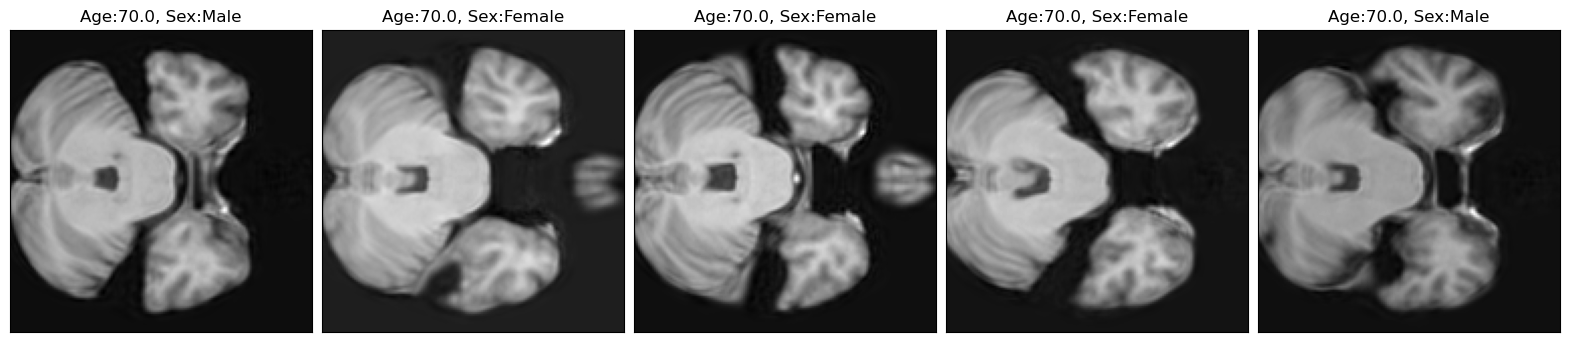

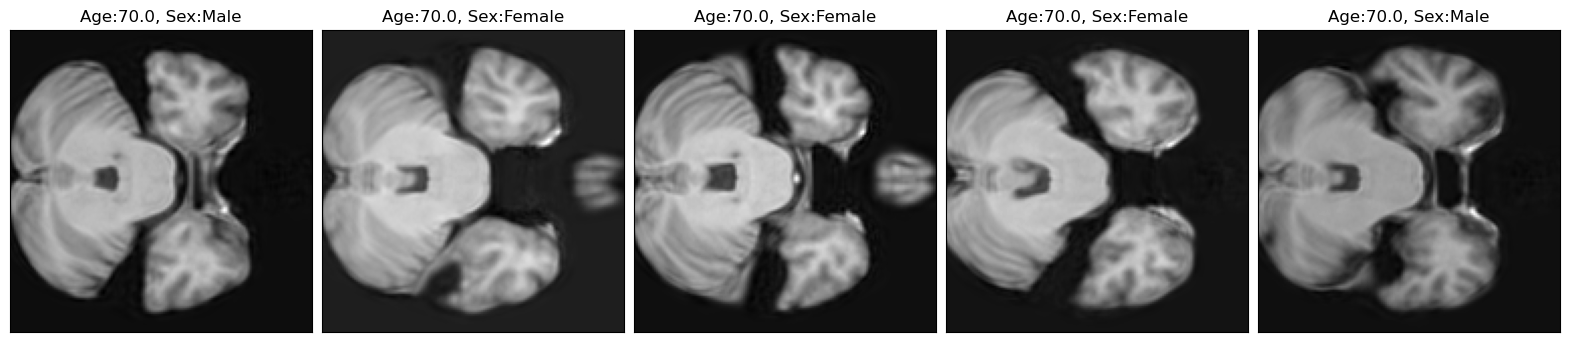

In [27]:
plt.rcParams["figure.figsize"] = (20,5)
img_grid([one_image.reshape(150,150) for one_image in decoded_cf],cols=nsamples,titles=titles_cf)

In [28]:
decoded_cf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
X_obs.shape

(5, 52)